In [2]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pwd

'/Users/anna/Desktop/AIRMET_CASE_ECHO'

### DATABASES FROM BIG QUERY

In [5]:
# Let´s import the data - for Start Stations

start_stations = pd.read_csv('/Users/anna/Desktop/AIRMET_CASE_ECHO/data/start_date_start_station.csv')


# Let´s change the column names to a relavant names

start_stations.columns = ['date_day','start_station_id','count_rental_ids']
start_stations.head()

,date_day,start_station_id,count_rental_ids
0,2017-02-19,332.0,4
1,2015-07-30,242.0,6
2,2015-11-23,14.0,4
3,2015-06-16,154.0,4
4,2015-07-23,407.0,5


In [6]:
# In order to not be extremely granular in our predicitons, and save some processing time,
# we will aggregate the data on a weekly basis

In [7]:
start_stations['date_day'] =  pd.to_datetime(start_stations['date_day'], format='%Y-%m-%d')

In [8]:
start_stations["Day_of_Week"] = start_stations['date_day'].dt.weekday

In [9]:
start_stations.head()

,date_day,start_station_id,count_rental_ids,Day_of_Week
0,2017-02-19,332.0,4,6
1,2015-07-30,242.0,6,3
2,2015-11-23,14.0,4,0
3,2015-06-16,154.0,4,1
4,2015-07-23,407.0,5,3


In [14]:
# Let´s now find out the date of each commencing week
from datetime import datetime, timedelta

In [15]:
start_stations["First_day_of_the_week"] = start_stations.apply(lambda x: x['date_day'] - timedelta(days=x['Day_of_Week']), axis=1)

KeyboardInterrupt: 

In [16]:
# Let's first aggregate the dataset with start date and count of rentals
# by week

rentals_by_week=start_stations.groupby(['First_day_of_the_week']).sum()

In [17]:
rentals_by_week = rentals_by_week.drop(['start_station_id','Day_of_Week'],axis =1)

In [18]:
# Let´s limit our data set to full weeks
rentals_by_week = rentals_by_week['2015-01-05':'2017-06-05']

In [19]:
rentals_by_week.head()

,count_rental_ids
First_day_of_the_week,
2015-01-05,130305
2015-01-12,139559
2015-01-19,146865
2015-01-26,133247
2015-02-02,134438


In [21]:
# let´s export the table to a csv
rentals_by_week.to_csv(r'/Users/anna/Desktop/AIRMET_CASE_ECHO/tableau_data/rentals_by_week.csv')

### Goal 1 - FIND THE OPTIMUM WINDOW POR THE CAMPAIGN

In [388]:
# Quick check that numbers add up

total_start_stations = start_stations['count_rental_ids'].sum()
total_rentals_by_week = rentals_by_week['count_rental_ids'].sum()

print('The table of start stations adds up to',total_start_stations)
print('The table of stations by date adds up to',total_rentals_by_date)

The table of start stations adds up to 24369201
The table of stations by date adds up to 24369201


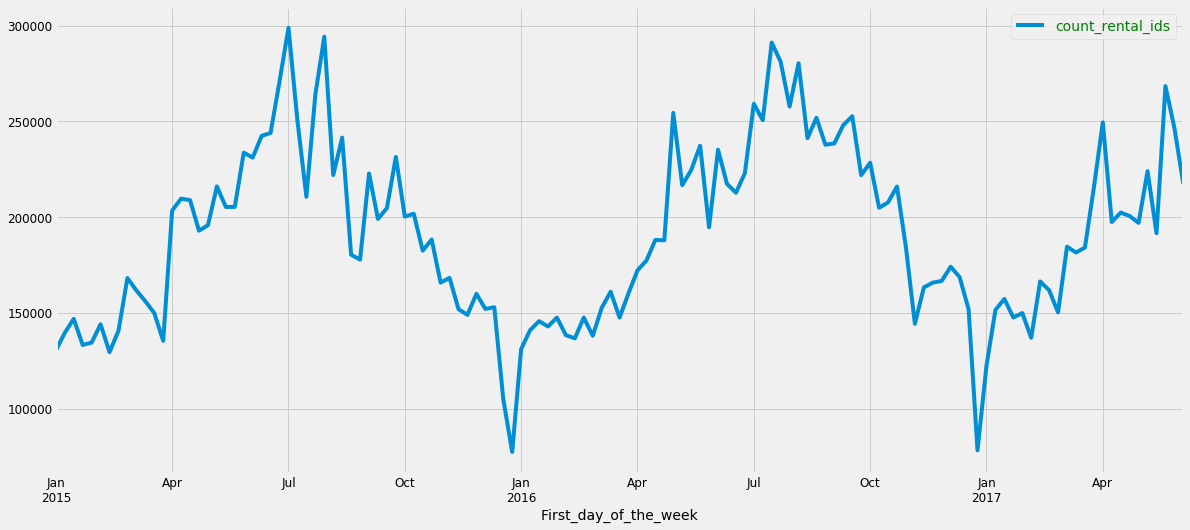

In [389]:
# Let´s plot the rental volume by week
rentals_by_week.plot.line( y='count_rental_ids')

### Let´s try the SARIMA predictive model approach to predict rental volumes

In [391]:
# Let's import all relevant libraries

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

In [392]:
# Let´s rename the dataset for ease of use
df_week = rentals_by_week

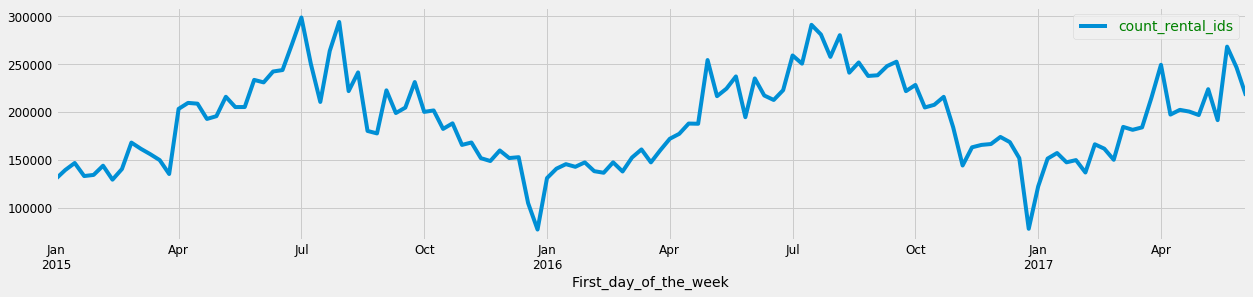

In [393]:
# Below a graph of cumulative rentals per week
# We can automatically see there is a spike betweej July and August in usage, there is clear seasonality
df_week.plot(figsize=(19,4))
plt.show()

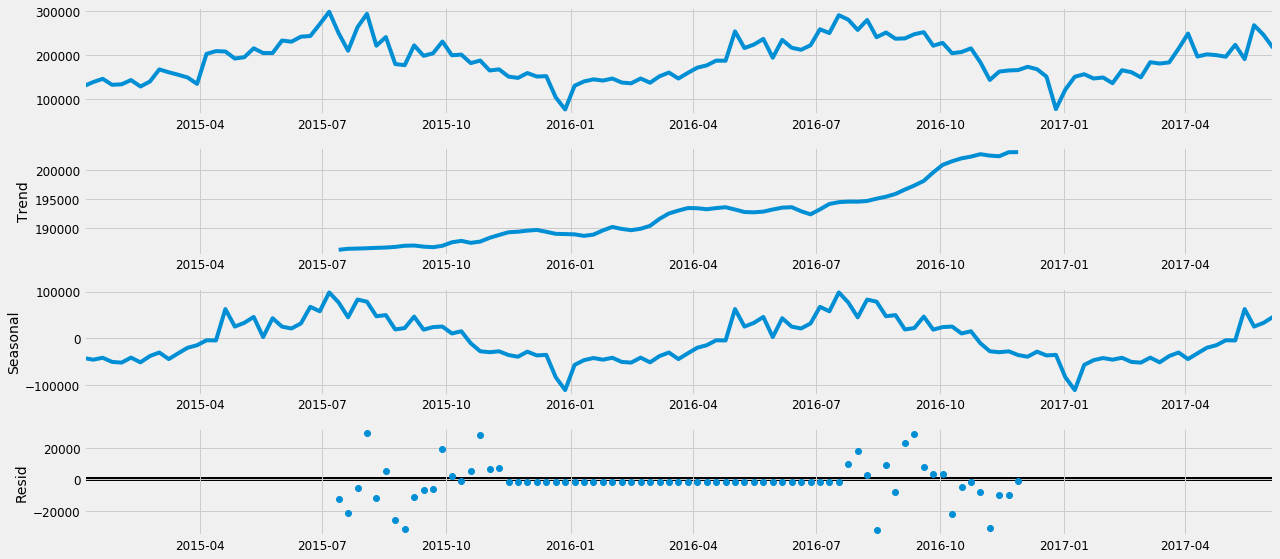

In [394]:
# Let´s decompose the time-series into three distinct components: trend, seasonality, and noise.
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_week, model='additive',period=54)
fig = decomposition.plot()
plt.show()

In [410]:
# Let´s find the optimal AIC (Akaike information criterion) which is an estimator of the relative quality of
# statistical models for a given set of data.
from pmdarima import auto_arima
stepwise_model = auto_arima(df_week, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=52,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,52) [intercept=True]; AIC=1733.175, BIC=1744.695, Time=4.015 seconds
Fit ARIMA(0,1,0)x(0,1,0,52) [intercept=True]; AIC=1768.362, BIC=1772.970, Time=0.377 seconds
Fit ARIMA(1,1,0)x(1,1,0,52) [intercept=True]; AIC=1731.341, BIC=1740.558, Time=2.917 seconds
Near non-invertible roots for order (1, 1, 0)(1, 1, 0, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.993)
Fit ARIMA(0,1,1)x(0,1,1,52) [intercept=True]; AIC=1731.329, BIC=1740.546, Time=2.294 seconds
Fit ARIMA(0,1,0)x(0,1,0,52) [intercept=False]; AIC=1767.770, BIC=1770.074, Time=0.499 seconds
Fit ARIMA(0,1,1)x(0,1,0,52) [intercept=True]; AIC=1749.769, BIC=1756.681, Time=0.378 seconds
Fit ARIMA(0,1,1)x(1,1,1,52) [intercept=True]; AIC=1730.618, BIC=1742.138, Time=4.728 seconds
Fit ARIMA(0,1,1)x(1,1,0,52) [intercept=True]; AIC=1729.939, BIC=1739.156, Time=2.833 seconds
Fit ARIMA(0,1,1)x(2,1,0,52) [intercept=True]; AIC=173

In [423]:
# Let´s include the combination with highest AIC
mod = sm.tsa.statespace.SARIMAX(df_week,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5525      0.277     -1.996      0.046      -1.095      -0.010
ar.S.L52      -0.5390      0.310     -1.738      0.082      -1.147       0.069
sigma2      1.059e+09   8.12e-11    1.3e+19      0.000    1.06e+09    1.06e+09


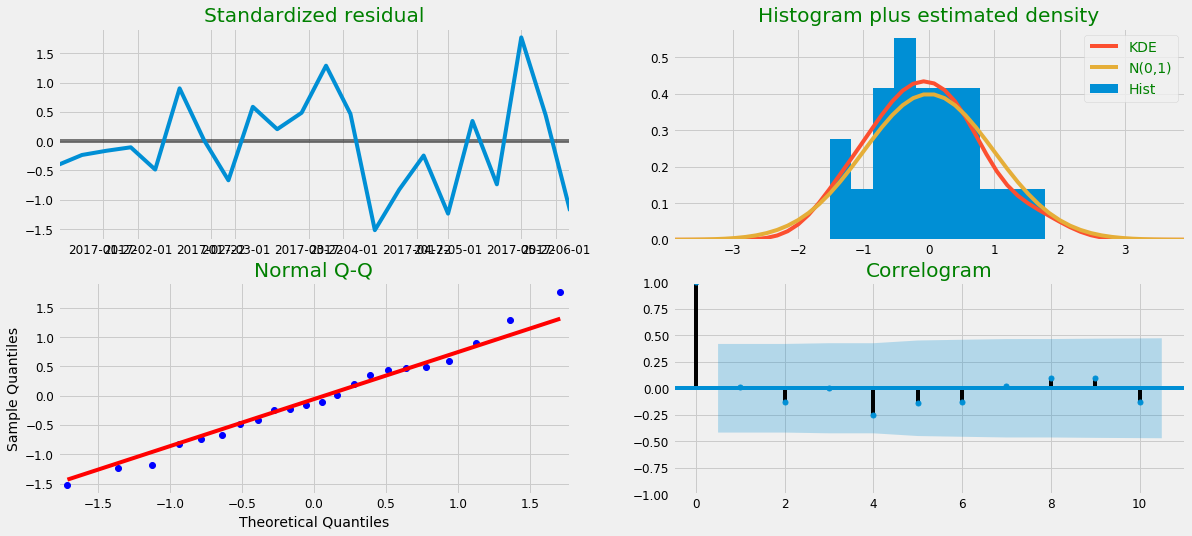

In [424]:
# Diagnostics
results.plot_diagnostics(figsize=(18, 8))
plt.show()

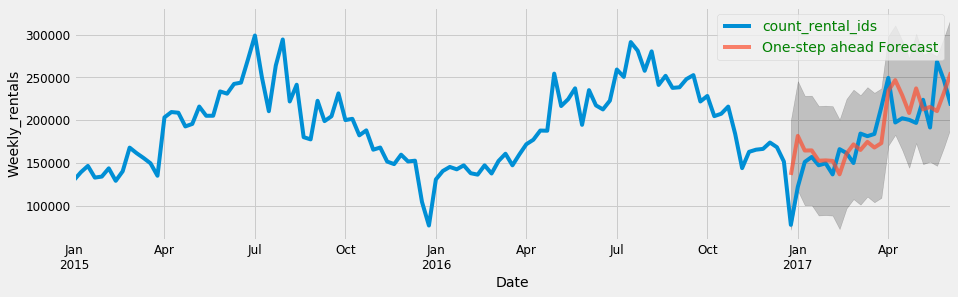

In [426]:
# Let´s the true values with the forecast predictions.
pred = results.get_prediction(start=pd.to_datetime('2016-12-26'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_week['2015-01-04':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Weekly_rentals')
plt.legend()
plt.show()

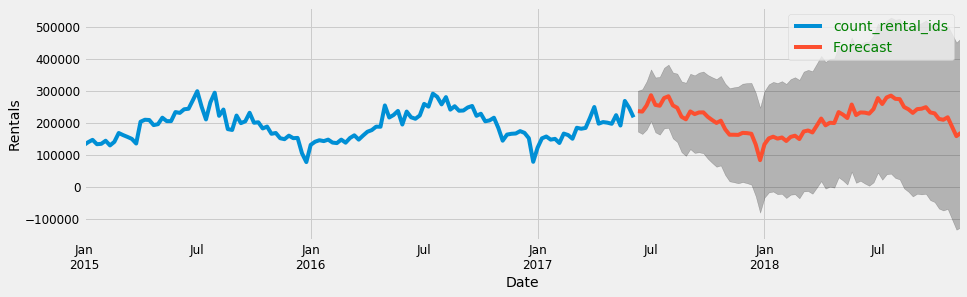

In [427]:
# Let´s use the established model for future forecast of 75 weeks
pred_uc = results.get_forecast(steps=75)
pred_ci = pred_uc.conf_int()
ax = df_week.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Rentals')
plt.legend()
plt.show()

In [428]:
# Let´s look at the lower & upper which the model indicate as boundaries for the forecasting
pred_ci.head(24)

,lower count_rental_ids,upper count_rental_ids
2017-06-12,172726.144167,300267.908885
2017-06-19,165305.482385,305033.447515
2017-06-26,178961.962084,329895.413417
2017-07-03,205505.847185,366868.510844
2017-07-10,170510.982055,341668.546057
2017-07-17,163164.530674,343586.021098
2017-07-24,182827.002233,372059.443159
2017-07-31,184177.114314,381828.117831
2017-08-07,151641.276787,357366.631770
2017-08-14,140242.946484,353737.499517


In [431]:
# This is the future forecast until 2018 for Bike Rentals
forecast = pred_uc.predicted_mean
forecast.head(75)

2017-06-12    236497.026526
2017-06-19    235169.464950
2017-06-26    254428.687751
2017-07-03    286187.179014
2017-07-10    256089.764056
                  ...      
2018-10-15    209615.705725
2018-10-22    217322.527153
2018-10-29    187831.167380
2018-11-05    158455.374482
2018-11-12    168676.887665
Freq: W-MON, Length: 75, dtype: float64

In [449]:
# Let's translate it into a dataframe and create a rolling 3 week calculation
forecast_df = pd.DataFrame(forecast)

In [450]:
# Let´s rename the column to a relevant name
forecast_df.columns = ['rentals_forecasted_week_c']

In [452]:
# Rolling 3 week forecast - let's see the 3 weeks with maximum impact
# We first need to create a new variable with 3 rolling weeks addition
forecast_df ['rentals_3_rolling_weeks'] = forecast_df['rentals_forecasted_week_c'].rolling(min_periods=1, window=3).sum()


In [453]:
forecast_df.tail()

,rentals_forecasted_week_c,rentals_3_rolling_weeks
2018-10-15,209615.705725,651556.285067
2018-10-22,217322.527153,639255.118751
2018-10-29,187831.167380,614769.400258
2018-11-05,158455.374482,563609.069015
2018-11-12,168676.887665,514963.429526


In [455]:
# Let's now find out what is the maximum rentals for 3 rolling weeks
forecast_df.loc[forecast_df['rentals_3_rolling_weeks'].idxmax()]

rentals_forecasted_week_c    274996.649689
rentals_3_rolling_weeks      839394.623670
Name: 2018-07-30 00:00:00, dtype: float64

### For maximum reach, the campgaign should be active from to 16-07-2018 - 05-08-2018

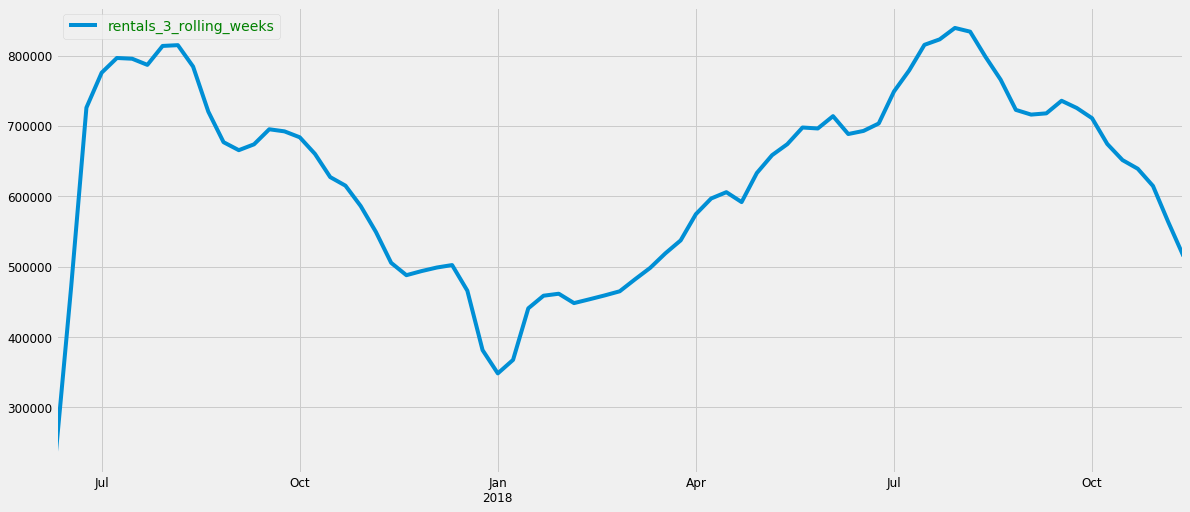

In [458]:
forecast_df.plot.line( y='rentals_3_rolling_weeks')